In [127]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [128]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

### Want something like:

    SELECT
        table4.countrycode as 'countrycode',
        b.table1 as 'table1',
        b.table2 as 'table2',
        b.table3 as 'table3',
        table4.year as 'table4'
        (SELECT
            table3.countrycode as 'countrycode',
            a.table1 as 'table1',
            a.table2 as 'table2',
            table3.year as 'table3'
         FROM
            (SELECT
                 table1.countrycode as 'countrycode',
                 table1.year as 'table1',
                 table2.year as 'table2'
             FROM
                 table1
             JOIN
                 table2
               ON 
                 table1.countrycode = table2.countrycode
             ) a
         JOIN
             table3
           ON
             a.countrycode = table3.countrycode  
        ) b    
    JOIN
        table4
      ON
        a.countrycode = table3.countrycode 
    
        
       


In [129]:
def makeSQLQuery(table_names, year):
    dotyyear = '.y' + str(year)
    current_unit = 'a'
    query = '(SELECT ' + table_names[0] + '.countrycode AS countrycode, ' + \
            table_names[0] + dotyyear + ' AS ' + table_names[0] + ', ' + \
            table_names[1] + dotyyear + ' AS ' + table_names[1] + \
            ' FROM ' + table_names[0] + \
            ' JOIN ' + table_names[1] + \
            ' ON ' + table_names[0] + '.countrycode=' + table_names[1] + '.countrycode) '
    query = query + current_unit
    
    for table in table_names[2:]:
        curr_index = table_names.index(table)
        temp_list = table_names[:curr_index+1]
        
        pre_string = '(SELECT ' + table + '.countrycode as countrycode'
        
        for temp_table in temp_list[:-1]:
            pre_string = pre_string + ', ' + current_unit + '.' + temp_table + ' AS ' + temp_table
        
        pre_string = pre_string + ', ' + table + dotyyear + ' AS ' + table
        
        query = pre_string + ' FROM ' + query + ' JOIN ' + table + \
                ' ON ' + current_unit + '.countrycode=' + table + '.countrycode) '
        
        current_unit = current_unit + 'a'
        query = query + current_unit
        
    query = query.rsplit(' ', 1)[0][1:-1]
    
    return query
    
    

In [130]:
table_names = ['corruption_perception', 'life_expectancy', \
               'population_15_64', 'population_65_up', \
                'zscores']

In [131]:
query = makeSQLQuery(table_names, 2013)

In [132]:
data_2013 = pd.read_sql_query(query, engine)

In [133]:
data_2013 = data_2013.set_index('countrycode')

In [134]:
data_2013['zscores'] = data_2013['zscores'].astype(float)

In [135]:
data_2013.head()

,corruption_perception,life_expectancy,population_15_64,population_65_up,zscores
countrycode,,,,,
AFG,8,60.028268,51.920329,2.394414,6.005490
AGO,23,51.866171,49.673340,2.314084,-0.232733
ALB,31,77.537244,68.848024,11.769682,-0.003833
ARE,69,77.195634,85.340053,0.941861,-0.265036
ARG,34,75.986098,63.834426,10.699832,-0.265098


In [136]:

data_2013.loc[data_2013['zscores'] > 0, 'zscores'] = 1
data_2013.loc[data_2013['zscores'] <= 0, 'zscores'] = 0


In [137]:
#The rows to be dropped
data_2013[data_2013.isnull().any(axis=1)]

,corruption_perception,life_expectancy,population_15_64,population_65_up,zscores
countrycode,,,,,
BLZ,NaN,69.982049,62.518994,3.758938,0
FJI,NaN,69.917927,65.713066,5.441534,0
GRD,NaN,73.193561,66.079961,7.154728,0
KIR,NaN,65.766585,61.033314,3.610517,0
MAC,NaN,80.339146,79.257855,8.119094,0
MDV,NaN,76.602610,67.509135,4.775128,0
SLB,NaN,67.718927,56.518544,3.367845,0
TON,NaN,72.640341,56.966492,5.886493,0
VUT,NaN,71.669244,58.783797,4.044398,0


In [138]:
data_2013 = data_2013.dropna()

In [139]:
def getScoreValues(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=6), verbose=True):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)
    
    try:
        print(model.feature_importances_)
    except AttributeError:
        pass
    
    if verbose:
        #print(pd.concat([y_test,pd.Series(y_pred, index=y_test.index)], axis = 1))
        print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(accuracy_score_value, \
                                                                       precision_score_value, \
                                                                       recall_score_value, \
                                                                       f1_score_value))
    
    return accuracy_score_value, precision_score_value, recall_score_value, f1_score_value

In [140]:
X = data_2013[['corruption_perception', 'life_expectancy', \
               'population_15_64', 'population_65_up']]
y = data_2013['zscores']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [141]:
getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

[ 0.38033117  0.29900753  0.23792448  0.08273682]
Accuracy: 0.8627450980392157
Precision: 0.2857142857142857
Recall: 0.5
f1: 0.36363636363636365


(0.86274509803921573, 0.2857142857142857, 0.5, 0.36363636363636365)

In [142]:
getScoreValues(X_train, X_test, y_train, y_test, BernoulliNB())

Accuracy: 0.9215686274509803
Precision: 0.0
Recall: 0.0
f1: 0.0


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.92156862745098034, 0.0, 0.0, 0.0)

In [143]:
getScoreValues(X_train, X_test, y_train, y_test, GaussianNB())

Accuracy: 0.8431372549019608
Precision: 0.25
Recall: 0.5
f1: 0.3333333333333333


(0.84313725490196079, 0.25, 0.5, 0.33333333333333331)

In [144]:
getScoreValues(X_train, X_test, y_train, y_test, model=SVC())

Accuracy: 0.9215686274509803
Precision: 0.0
Recall: 0.0
f1: 0.0


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.92156862745098034, 0.0, 0.0, 0.0)

In [145]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

[ 0.25944932  0.27431297  0.22745312  0.23878459]
Accuracy: 0.9411764705882353
Precision: 0.6666666666666666
Recall: 0.5
f1: 0.5714285714285715


(0.94117647058823528, 0.66666666666666663, 0.5, 0.57142857142857151)

In [146]:
def getROCcurve(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=6)):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
    print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc='best')

AUC: 0.9148936170212766


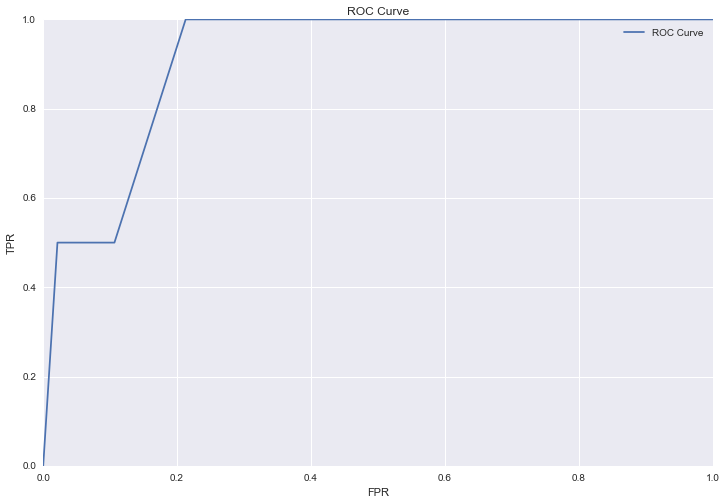

In [147]:
getROCcurve(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

In [148]:
def getScoreValuesByCV(X, y, model=KNeighborsClassifier(n_neighbors=5)):
    
    accuracy_score_value = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    precision_score_value = np.mean(cross_val_score(model, X, y, scoring='precision', cv=5))
    recall_score_value = np.mean(cross_val_score(model, X, y, scoring='recall', cv=5))
    f1_score_value = np.mean(cross_val_score(model, X, y, scoring='f1', cv=5))
    roc_auc_value = np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=5))
    #roc_auc_value = 0  
        
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(accuracy_score_value, \
                                                                   precision_score_value, \
                                                                   recall_score_value, \
                                                                   f1_score_value,
                                                                   roc_auc_value))

In [149]:
getScoreValuesByCV(X,y)

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8521670486376369
Precision: 0.5
Recall: 0.19333333333333336
f1: 0.2666666666666667
ROC AUC: 0.6422495894909688


In [150]:
getScoreValuesByCV(X,y, model=RandomForestClassifier())

Accuracy: 0.8284491978609626
Precision: 0.4
Recall: 0.23333333333333334
f1: 0.28701298701298705
ROC AUC: 0.6936124794745486


In [151]:
getScoreValuesByCV(X,y, model=GaussianNB())

Accuracy: 0.7630099312452253
Precision: 0.3437445887445888
Recall: 0.5
f1: 0.40230769230769237
ROC AUC: 0.7106732348111657


In [152]:
getScoreValuesByCV(X,y, model=DecisionTreeClassifier())

Accuracy: 0.7981563534504712
Precision: 0.325
Recall: 0.30666666666666664
f1: 0.29015873015873017
ROC AUC: 0.5970525451559935


In [153]:
getScoreValuesByCV(X,y, model=LogisticRegression())

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/met

Accuracy: 0.8462846956964605
Precision: 0.0
Recall: 0.0
f1: 0.0
ROC AUC: 0.6753694581280788


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Over sampling

In [154]:
x_cols = ['corruption_perception', 'life_expectancy', \
               'population_15_64', 'population_65_up']

In [155]:
X = data_2013[x_cols]
y = data_2013['zscores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [156]:
verbose = False
ratio = float(y.value_counts()[0]) / float(y.value_counts()[1])
X_train = X_train.reset_index(drop=True).as_matrix()
y_train = y_train.reset_index(drop=True).as_matrix()

smote = SMOTE(ratio=ratio, verbose=verbose)
smox, smoy = smote.fit_transform(X_train, y_train)

In [157]:
smox

array([[ 20.        ,  67.77204878,  63.96682071,   3.93080535],
       [ 45.        ,  73.90141463,  60.13272381,   3.76568713],
       [ 41.        ,  74.46585366,  66.76508737,  19.36866524],
       [ 44.        ,  75.18704878,  70.87910842,  11.7906842 ],
       [ 46.        ,  79.25639024,  69.88520577,  13.30639678],
       [ 83.        ,  81.10487805,  66.00651062,  17.14151995],
       [ 30.        ,  50.36312195,  54.39478389,   2.66754752],
       [ 28.        ,  71.07317073,  70.94620524,  13.16186509],
       [ 38.        ,  60.52039024,  54.08343216,   3.03654757],
       [ 42.        ,  76.27692683,  71.55186054,  14.50012332],
       [ 40.        ,  75.35302439,  73.95641056,   8.88928751],
       [ 29.        ,  59.13236585,  54.67229945,   2.74907959],
       [ 37.        ,  61.466     ,  51.03697772,   3.37157351],
       [  8.        ,  69.79195122,  68.84963491,   9.45878416],
       [ 27.        ,  71.2452439 ,  64.58821148,   4.91391834],
       [ 28.        ,  65

In [158]:
X_train = pd.DataFrame(smox, columns=x_cols)
y_train = pd.Series(smoy)

In [159]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

[ 0.32563542  0.23178386  0.26370984  0.17887088]
Accuracy: 0.8431372549019608
Precision: 0.3
Recall: 0.75
f1: 0.4285714285714285


(0.84313725490196079, 0.29999999999999999, 0.75, 0.42857142857142849)

In [160]:
getScoreValues(X_train, X_test, y_train, y_test, model=BernoulliNB())

Accuracy: 0.0784313725490196
Precision: 0.0784313725490196
Recall: 1.0
f1: 0.14545454545454545


(0.078431372549019607, 0.078431372549019607, 1.0, 0.14545454545454545)

In [161]:
getScoreValues(X_train, X_test, y_train, y_test, model=GaussianNB())

Accuracy: 0.5294117647058824
Precision: 0.08333333333333333
Recall: 0.5
f1: 0.14285714285714285


(0.52941176470588236, 0.083333333333333329, 0.5, 0.14285714285714285)

In [162]:
getScoreValues(X_train, X_test, y_train, y_test, model=DecisionTreeClassifier())

[ 0.31589153  0.32677885  0.20883952  0.1484901 ]
Accuracy: 0.8627450980392157
Precision: 0.3333333333333333
Recall: 0.75
f1: 0.46153846153846156


(0.86274509803921573, 0.33333333333333331, 0.75, 0.46153846153846156)

In [163]:
getScoreValues(X_train, X_test, y_train, y_test)

Accuracy: 0.6078431372549019
Precision: 0.13636363636363635
Recall: 0.75
f1: 0.23076923076923075


(0.60784313725490191, 0.13636363636363635, 0.75, 0.23076923076923075)

## Cross validate with oversampling

In [164]:
def getCrossValScoresBySKF(local_X, local_y, n_iter=30, test_size=0.3, model=KNeighborsClassifier(n_neighbors=6), get_models_avg=False):
    acc_array = []
    prec_array = []
    recall_array = []
    f1_array = []
    sss = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size)
    
    model_list = [\
                  KNeighborsClassifier(n_neighbors=6), \
                  LogisticRegression(), \
                  GaussianNB(), \
                  RandomForestClassifier(), \
                  DecisionTreeClassifier() \
                  ]
    
    
    for train_index, test_index in sss:
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.ix[train_index], X.ix[test_index]
        y_train, y_test = y.ix[train_index], y.ix[test_index]
        
        X_train = X_train.reset_index(drop=True).as_matrix()
        y_train = y_train.reset_index(drop=True).as_matrix()

        smote = SMOTE(ratio=ratio, verbose=verbose)
        smox, smoy = smote.fit_transform(X_train, y_train)
        X_train = pd.DataFrame(smox, columns=x_cols)
        y_train = pd.Series(smoy)
        
        if get_models_avg:
            y_predictions = []
            
            for a_model in model_list:
                temp_model = a_model
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_predictions.append(y_pred)
                
            average_prediction = np.mean(y_predictions, axis=0)
            average_prediction = [int(round(n, 0)) for n in average_prediction]

            accuracy_score_value = accuracy_score(y_test, y_pred)
            precision_score_value = precision_score(y_test, y_pred)
            recall_score_value = recall_score(y_test, y_pred)
            f1_score_value = f1_score(y_test, y_pred)
            
            acc_array.append(accuracy_score_value)
            prec_array.append(precision_score_value)
            recall_array.append(recall_score_value)
            f1_array.append(f1_score_value)
        
        else:
        
            accuracy_score_value, precision_score_value, \
            recall_score_value, f1_score_value = \
                                                getScoreValues(X_train, X_test, y_train, y_test, model=model, verbose=False)

            acc_array.append(accuracy_score_value)
            prec_array.append(precision_score_value)
            recall_array.append(recall_score_value)
            f1_array.append(f1_score_value)
        
    mean_acc = np.mean(acc_array)
    mean_prec = np.mean(prec_array)
    mean_recall = np.mean(recall_array)
    mean_f1 = np.mean(f1_array)
    
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(mean_acc, \
                                                                   mean_prec, \
                                                                   mean_recall,\
                                                                   mean_f1))

In [165]:
X = data_2013[x_cols]
y = data_2013['zscores']

#### KNN various n


In [166]:
for n in range(1,8):
    print('n = ', n)
    getCrossValScoresBySKF(X, y, model=KNeighborsClassifier(n_neighbors=n))
    print('\n')

n =  1
Accuracy: 0.6993464052287585
Precision: 0.25465373333710256
Recall: 0.4666666666666667
f1: 0.3242420195025821


n =  2
Accuracy: 0.7464052287581702
Precision: 0.22909844784844785
Recall: 0.31666666666666665
f1: 0.2603541465588848


n =  3
Accuracy: 0.6562091503267976
Precision: 0.2269099328890351
Recall: 0.49166666666666664
f1: 0.3080699852682082


n =  4
Accuracy: 0.7058823529411767
Precision: 0.25506160970092856
Recall: 0.4625
f1: 0.32501983357208375


n =  5
Accuracy: 0.6575163398692813
Precision: 0.24350735882624427
Recall: 0.5666666666666667
f1: 0.33718769440702595


n =  6
Accuracy: 0.6823529411764707
Precision: 0.2533291726781766
Recall: 0.5041666666666667
f1: 0.3318368912109079


n =  7
Accuracy: 0.6189542483660132
Precision: 0.2302516715389691
Recall: 0.6083333333333333
f1: 0.33007790406912424




#### Logistic Regression

In [167]:
getCrossValScoresBySKF(X, y, model=LogisticRegression())

Accuracy: 0.5333333333333333
Precision: 0.20232950307349656
Recall: 0.675
f1: 0.3096609127430187


#### GaussianNB

In [168]:
getCrossValScoresBySKF(X, y, model=GaussianNB())

Accuracy: 0.5980392156862745
Precision: 0.23048529626299175
Recall: 0.6583333333333333
f1: 0.33819548793324794


#### BernoulliNB

In [169]:
getCrossValScoresBySKF(X, y, model=BernoulliNB())

Accuracy: 0.15686274509803924
Precision: 0.15686274509803924
Recall: 1.0
f1: 0.27118644067796616


#### Random Forest

In [170]:
getCrossValScoresBySKF(X, y, model=RandomForestClassifier())

[ 0.29092026  0.26805034  0.2477843   0.19324511]
[ 0.33123398  0.26622879  0.2519017   0.15063553]
[ 0.33258661  0.25245663  0.27165993  0.14329684]
[ 0.39205381  0.21171676  0.22671666  0.16951277]
[ 0.23158925  0.32903944  0.2582127   0.18115861]
[ 0.3311209   0.2941901   0.18987954  0.18480946]
[ 0.34861371  0.26163096  0.21385379  0.17590155]
[ 0.34867519  0.25356258  0.22654479  0.17121744]
[ 0.25365824  0.25025502  0.27158025  0.22450649]
[ 0.35148141  0.2621886   0.19495321  0.19137678]
[ 0.23639257  0.20325861  0.4053949   0.15495391]
[ 0.25368788  0.24574864  0.30587492  0.19468856]
[ 0.17304542  0.23943028  0.37492997  0.21259433]
[ 0.23847633  0.24413709  0.2617652   0.25562138]
[ 0.24614697  0.2773498   0.30494077  0.17156247]
[ 0.26602074  0.22494715  0.34303623  0.16599588]
[ 0.34767231  0.25762437  0.20069511  0.1940082 ]
[ 0.30847683  0.28048407  0.2732752   0.1377639 ]
[ 0.38574141  0.23183486  0.24751871  0.13490503]
[ 0.35074418  0.26270182  0.19896704  0.18758696]


#### DecisionTreeClassifier

In [171]:
getCrossValScoresBySKF(X, y, model=DecisionTreeClassifier())

[ 0.30704908  0.43574818  0.18629656  0.07090618]
[ 0.29538908  0.08959203  0.37742975  0.23758914]
[ 0.15338228  0.43385461  0.25597268  0.15679042]
[ 0.20415143  0.3801639   0.25597282  0.15971185]
[ 0.19484207  0.31409172  0.28112675  0.20993945]
[ 0.18978576  0.39649685  0.24105557  0.17266183]
[ 0.23011984  0.39780136  0.28851075  0.08356804]
[ 0.2561746   0.19973783  0.39729577  0.1467918 ]
[ 0.33253372  0.33855861  0.29209003  0.03681765]
[ 0.38854718  0.24145114  0.15697654  0.21302514]
[ 0.16275228  0.34135508  0.33825281  0.15763983]
[ 0.15247899  0.37445706  0.31985037  0.15321359]
[ 0.51937021  0.11627499  0.17174994  0.19260486]
[ 0.30570807  0.31042181  0.22174129  0.16212883]
[ 0.31736649  0.34074976  0.22810455  0.1137792 ]
[ 0.43165945  0.21946317  0.18678052  0.16209687]
[ 0.37167609  0.38844166  0.22203737  0.01784487]
[ 0.31859349  0.26174858  0.20685663  0.2128013 ]
[ 0.16026218  0.3288757   0.30576241  0.20509971]
[ 0.24030081  0.33888872  0.31517067  0.1056398 ]


### Model averages:

In [172]:
getCrossValScoresBySKF(X, y, get_models_avg=True)

Accuracy: 0.673856209150327
Precision: 0.2508512150617414
Recall: 0.525
f1: 0.33491431661373017
